In [1]:
import numpy as np
import scipy.fftpack as fftpack
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline
font_prop = font_manager.FontProperties(size=16)

# Using Fourier Analysis to Analyze Quasi-Periodic Oscillations

By Abigail Stevens

# Problem 1: damped harmonic oscillator example
## Generating a light curve

In [2]:
a = Table()
a.meta['dt'] = 0.01  # time step, in seconds
a.meta['duration'] = 200 # length of time, in seconds
a.meta['omega'] = 2*np.pi  # angular frequency, in radians
a.meta['phi'] = 0.0  # offset angle, in radians

### 1a. Compute the time steps and a cosine harmonic with the above-defined properties.

In [3]:
time_steps = np.arange(0, a.meta['duration'] + a.meta['dt'], a.meta['dt'])
amplitudes = np.cos(a.meta['omega'] * time_steps + a.meta['phi'])

### 1b. Compute four exponentially damped versions of the harmonic oscillation. 
$$D(t_i) = e^{-\zeta t_i}H(t_i)$$
Pick your own four $\zeta$s! I recommend values between 0.01 and 1.

In [4]:
def dampen(time_steps, amplitudes, zeta):
    damp_factor = np.exp(-1.0 * zeta * time_steps)
    return amplitudes * damp_factor

zeta_dict = {}
for zeta in [0.01, 0.1, 0.4, 1.0]:
    zeta_dict[zeta] = dampen(time_steps, amplitudes, zeta)

### 1c. Plot them all on top of each other.

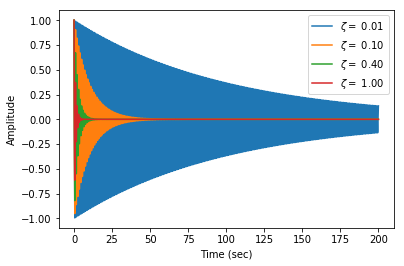

In [5]:
plt.figure()
for zeta, values in zeta_dict.items():
    plt.plot(time_steps, values, label=r'$\zeta =$ %.2f' % zeta)
plt.legend()
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.show()

### 1d. Take the power spectrum of the harmonic and 4 damped harmonic time series.
The power $P$ at each frequency $\nu_i$, for the Fourier transform $F$, is $$P(\nu_i)=|F(\nu_i)|^2$$

In [6]:
power_dict = {}
for zeta, amp in zeta_dict.items():
    power_dict[zeta] = np.abs(fftpack.fft(amp))**2

Computing the Fourier frequencies and the index of the Nyquist frequency.

In [7]:
freq = fftpack.fftfreq(len(time_steps), d=a.meta['dt'])
nyq_ind = int(len(time_steps)/2.)  # the index of the last positive Fourier frequency

### 1e. Plot them! 
Notice the trend between the width of the peak in the power spectrum, and the strength of the damping factor.
For bonus points, put in a key/legend with the corresponding $\zeta$ value for each curve.



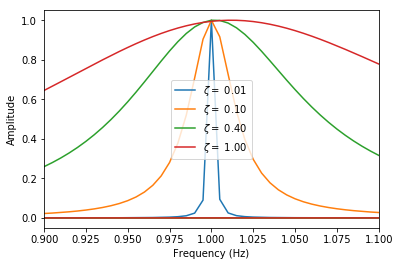

In [36]:
plt.figure()
for zeta, values in power_dict.items():
    plt.plot(freq, values / np.max(values), label=r'$\zeta =$ %.2f' % zeta)
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0.9, 1.1)
plt.show()

# Problem 2: Analyzing *NICER* data of the black hole X-ray binary MAXI J1535-571 

Import it with astropy tables from the file "J1535_evt.fits".

In [ ]:
! ls DSFP_Day4_data

In [12]:
from astropy.io import fits

In [25]:
filename = '/Users/rmorgan/Downloads/DSFP_Day4_data/J1535_evt.fits'
hdu = fits.open(filename)
data = hdu[1].data
hdu.close()

In [27]:
data[0:5]

FITS_rec([(1.1735203e+08, 163), (1.1735203e+08, 207),
          (1.1735203e+08, 181), (1.1735203e+08, 175),
          (1.1735203e+08, 262)],
         dtype=(numpy.record, [('TIME', '>f8'), ('ENERGY', '>i2')]))

The data have come to us as an 'event list', meaning that it's a list of the time at which a photon was detected (in seconds, in spacecraft clock time)  and what the energy of the photon was (a channel number; channel/100=photon energy in keV). 

### 2a. Turn this rag-tag list of photons into an evenly-spaced light curve 
2a.i. First, clean it up a little by only keeping photons with energies greater than 1 keV and less than 12 keV, using a mask. 

In [33]:
#Note that the units in the table are in 10*ev

In [28]:
tab = Table(data)

In [32]:
tab = tab[(tab['ENERGY'] > 100) & (tab['ENERGY'] < 1200)]

2a.ii. Then, make an evenly-spaced light curve array with `np.histogram`. Pick a light curve time resolution of `dt=1/8`seconds to start with. To put your light curve in units of count rate, divide the histogram (counts per bin) by `dt` (seconds per bin); to avoid typecasting errors, do this by multiplying by int(1/dt).

In [38]:
bins = np.arange(np.min(tab['TIME']), np.max(tab['TIME']) + 1./8, 1./8) 
values, bins = np.histogram(tab['TIME'], bins=bins)
counts = values * 8

(yes, it takes a second or two; you're using half a million time bins in your light curve!)

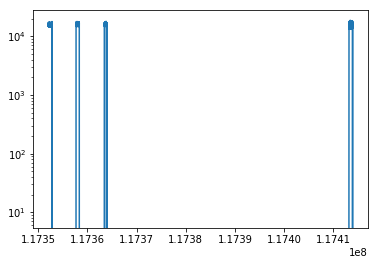

In [42]:
plt.figure()
plt.step(bins[0:-1], counts)
plt.yscale('log')
plt.show()

### 2b. Let's try taking the power spectrum of it.
$$P(\nu_i)=|F(\nu_i)|^2$$
where $F$ is the FFT of your light curve.

In [49]:
power_spectrum = np.abs(fftpack.fft(counts))**2

In [50]:
freq = fftpack.fftfreq(len(power_spectrum), d=1./8)
nyq_ind = int(len(power_spectrum)/2.)  # the index of the last positive Fourier frequency

Plot it!

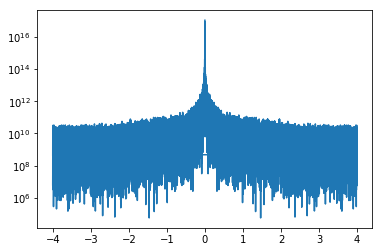

In [52]:
plt.figure()
plt.plot(freq, power_spectrum)
#plt.xlim(-0.005, 0.005)
plt.yscale('log')
plt.show()

It's ugly! But more importantly, you can't get useful science out of it. 
### What's going on?
1. There are gaps in the light curve due to the orbit of the spacecraft (and occasionally stuff gets in the way). This has the effect of inserting top-hat windows into our function, which give the lumpy bumps at ~0.25 Hz. So, we need to break the light curve up into shorter segments that won't have weird drop-outs.
2. There is a giant DC component at $\nu=0$. This is not astrophysical in origin, but from the mean of the light curve.
3. Power spectra are often plotted on log-log scales, but the power gets really noisy and 'scatter-y' at higher frequencies. 
4. The astute observer will notice that we can only go up to a Nyquist frequency of 4 Hz. There's interesting astrophysical signals above 4 Hz, but if we did smaller `dt` with keeping the very long segment length, we'd have >1 million time bins, which can be asking a lot of a laptop processor. 

### 2c. Segments!
2c.i. Turn your light curve code from 2a.ii. into a function:

In [53]:
def make_lc(events, start, end, dt):
    bins = np.arange(start, end + dt, dt) 
    values, bins = np.histogram(events, bins=bins)
    counts = values * 8
    return counts, bins

2c.ii. Sometimes, the detector is on and recording photons, but it's pointed too close to the Earth, or a structure on the spacecraft is occulting part of the view, or the instrument is moving through a zone of high particle background, or other things. The times when these things happen are recorded, and in data reduction you make a list of Good Time Intervals, or GTIs, which is when you can use good science data. I made a list of GTIs for this data file that are longer than 4 seconds long, which you can read in from "J1535_gti.fits".

In [54]:
filename = '/Users/rmorgan/Downloads/DSFP_Day4_data/J1535_gti.fits'
hdu = fits.open(filename)
gti_data = hdu[1].data
hdu.close()

In [55]:
gti_data[0:5]

FITS_rec([(1.17352030e+08, 1.17352785e+08),
          (1.17352787e+08, 1.17352802e+08),
          (1.17357673e+08, 1.17358342e+08),
          (1.17363425e+08, 1.17363885e+08),
          (1.17363889e+08, 1.17363902e+08)],
         dtype=(numpy.record, [('START', '>f8'), ('STOP', '>f8')]))

2c.iii. Not only do we want to only use data in the GTIs, but we want to split the light curve up into multiple equal-length segments, take the power spectrum of each segment, and average them together. By using shorter time segments, we can use finer `dt` on the light curves without having so many bins for the computation that our computer grinds to a halt. There is the added bonus that the noise amplitudes will tend to cancel each other out, and the signal amplitudes will add, and we get better signal-to-noise!

As you learned in Jess's lecture yesterday, setting the length of the segment determines the lowest frequency you can probe, but for stellar-mass compact objects where we're usually interested in variability above ~0.1 Hz, this is an acceptable trade-off.

In [56]:
time = np.asarray(tab['TIME'])  ## Doing this so that we can re-run
seg_length = 32. # seconds
dt = 1./128.# seconds
n_bins = int(seg_length/dt) # Number of time bins in a segment of light curve
psd_avg = np.zeros(n_bins)  # initiating, to keep running sum (then avearge at end)
n_seg = 0
for (start_gti, stop_gti) in zip(gti_data['START'], gti_data['STOP']):
    start_time = start_gti
    end_time = start_time + seg_length
    while end_time <= stop_gti:
        ## Make a mask of events in this segment
        events = time[np.where((time > start_time) & (time < end_time))]
        
        ## Keep the stuff not in this segment for next time

        ## Make the light curve
        counts_per_sec, _ = make_lc(events, start_time, end_time, dt)

        ## Turn that into a power spectrum
        psd = np.abs(fftpack.fft(counts_per_sec))**2

        ## Keep a running sum (to average at end)
        psd_avg += psd

        ## Print out progress
        if n_seg % 5 == 0:
            print(n_seg)
        ## Incrementing for next loop
        n_seg += 1
        start_time += seg_length
        end_time += seg_length
        
## Divide summed powers by n_seg to get the average
psd = psd_avg / n_seg

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75


Plot it! Use similar code I gave you above to make the array of Fourier frequencies and get the index of the Nyquist frequency.

In [57]:
freq = fftpack.fftfreq(len(psd), d=dt)

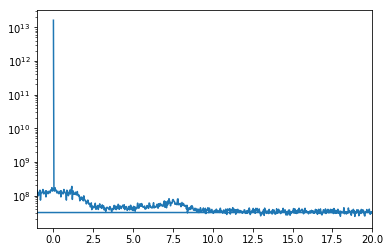

In [61]:
plt.figure()
plt.plot(freq, psd)
plt.xlim(-1, 20)
plt.yscale('log')
plt.show()

### 2d. Mean-subtracted
So, you can see something just to the left 10 Hz much clearer, but there's this giant whopping signal at the lowest frequency bin. This is what I've heard called the 'DC component', which arises from the mean count rate of the light curve. To get rid of it, subtract the mean from your light curve segment before taking the Fourier transform. Otherwise, keep the same code as above for 2c.iii. You may want to put some of this in a function for future use in this notebook.

### 2e. Error on average power
The average power at a particular frequency has a chi-squared distribution with two degrees of freedom about the true underlying power spectrum. So, error is the power value divided by the square root of the number of segments. A big reason why we love power spectra(/periodograms) is because this is so straight forward! 

One way to intuitively check if your errors are way-overestimated or way-underestimated is whether the size of the error bar looks commeasurate with the amount of bin-to-bin scatter of power at neighbouring frequencies.

Plotting, this time with `ax.errorbar` instead of `ax.plot`.

The thing at ~8 Hz is a low-frequency QPO, and the hump at-and-below 1 Hz is broadband noise (which we'll discuss in detail this afternoon)!! Now that you've got the basic analysis step complete, we'll focus on plotting the data in a meaningful way so you can easily extract information about the QPO and noise.

### 2f. Re-binning
We often plot power spectra on log-log scaled axes (so, log on both the X and Y), and you'll notice that there's a big noisy part above 10 Hz. It is common practice to bin up the power spectrum `geometrically` (which is like making it equal-spaced in when log-plotted). 

For this example, I'll use a re-binning factor of 1.03. If new bin 1 has the width of one old bin, new bin 2 will be some 1.03 bins wider. New bin 3 will be 1.03 times wider than *that* (the width of new bin 2), etc. For the first couple bins, this will round to one old bin (since you can only have an integer number of bins), but eventually a new bin will be two old bins, then more and more as you move higher in frequency. If the idea isn't quite sticking, try drawing out a representation of old bins and how the new bins get progressively larger by the rebinning factor.

For a given new bin `x` that spans indices `a` to `b` in the old bin array: 
$$\nu_{x} = \frac{1}{b-a}\sum_{i=a}^{b}\nu_{i}$$
$$P_{x} = \frac{1}{b-a}\sum_{i=a}^{b}P_{i}$$
$$\delta P_{x} = \frac{1}{b-a}\sqrt{\sum_{i=a}^{b}(\delta P_{i})^{2}}$$


In [ ]:
def rebin(freq, power, err_power, rebin_factor=1.05):
    """
    Re-bin the power spectrum in frequency space by some re-binning factor
    (rebin_factor > 1). This is sometimes called 'geometric re-binning' or 
    'logarithmic re-binning', as opposed to linear re-binning 
    (e.g., grouping by 2)

    Parameters
    ----------
    freq : np.array of floats
        1-D array of the Fourier frequencies.

    power : np.array of floats
        1-D array of the power at each Fourier frequency, with any/arbitrary
        normalization.

    err_power : np.array of floats
        1-D array of the error on the power at each Fourier frequency, with the
        same normalization as the power.

    rebin_factor : float
        The factor by which the data are geometrically re-binned.

    Returns
    -------
    rb_freq : np.array of floats
        1-D array of the re-binned Fourier frequencies.

    rb_power : np.array of floats
        1-D array of the power at the re-binned Fourier frequencies, with the
        same normalization as the input power array.

    rb_err : np.array of floats
        1-D array of the error on the power at the re-binned Fourier
        frequencies, with the same normalization as the input error on power.
    """
    assert rebin_factor >= 1.0

    rb_power = np.asarray([])  # Array of re-binned power
    rb_freq = np.asarray([])   # Array of re-binned frequencies
    rb_err = np.asarray([])    # Array of error in re-binned power
    real_index = 1.0           # The unrounded next index in power
    int_index = 1              # The int of real_index, added to current_m every iteration
    current_m = 1              # Current index in power
    prev_m = 0                 # Previous index m

    ## Loop through the length of the array power, new bin by new bin, to
    ## compute the average power and frequency of that new geometric bin.
    while current_m < len(power):



    return rb_freq, rb_power, rb_err

Apply this to the data (using JUST the frequency, power, and error at positive Fourier frequencies). Start with a rebin factor of 1.03.

Play around with a few different values of rebin_factor to see how it changes the plotted power spectrum. 1 should give back exactly what you put in, and 1.1 tends to bin things up quite a lot.

Congratulations! You can make great-looking power spectra! Now, go back to part 2d. and try 4 or 5 different combinations of `dt` and `seg_length`. What happens when you pick too big of a `dt` to see the QPO frequency? What if your `seg_length` is really short?

One of the most important things to notice is that for a real astrophysical signal, the QPO (and low-frequency noise) are present for a variety of different `dt` and `seg_length` parameters. 

### 2g. Normalization
The final thing standing between us and a publication-ready power spectrum plot is the normalization of the power along the y-axis. The normalization that's commonly used is fractional rms-squared normalization, sometimes just called the rms normalization. For a power spectrum created from counts/second unit light curves, the equation is:
$$P_{frac.rms2} = P \times \frac{2*dt}{N * mean^2}$$
`P` is the power we already have,
`dt` is the time step of the light curve,
`N` is `n_bins`, the number of bins in one segment, and
`mean` is the mean count rate (in counts/s) of the light curve (so, you will need to go back to 2d. and re-run keeping a running sum-then-average of the mean count rate).

Don't forget to apply the normalization to the error, and re-bin after!

### 2h. Poisson noise level
Notice that the Poisson noise is a power law with slope 0 at high frequencies. With this normalization, we can predict the power of the Poisson noise level from the mean counts/s rate of the light curve! 
$$P_{noise} = 2/mean$$

Compute this noise level, and plot it with the power spectrum.

Your horizontal Poisson noise line should be really close to the power at and above ~10 Hz.

### 2i.  For plotting purposes, we sometimes subtract the Poisson noise level from the power before plotting. 
Once we've done this and removed the noise, we can also plot the data in units of Power, instead of Power/Hz, by multiplying the power by the frequency. Recall that following the propagation of errors, you will need to multiply the error by the frequency as well, but not subtract the Poisson noise level there.

Beautiful! This lets us see the components clearly above the noise and see their *relative* contributions to the power spectrum (and thus to the light curve).

## Recap of what you learned in problem 2: 
You are now able to take a light curve, break it into appropriate segments using the given Good Time Intervals, compute the average power spectrum (without weird aliasing artefacts or a strong DC component), and plot it in such away that you can see the signals clearly.

# Problem 3: It's pulsar time
We are going to take these skills and now work on two different observations of the same source, the ultra-luminous X-ray pulsar Swift J0243.6+6124. The goal is for you to see how different harmonics in the pulse shape manifest in the power spectrum.

## 3a. Load the data and GTI
Using the files J0243-122_evt.fits and J0243-134_evt.fits, and the corresponding *x*_gti.fits.

## 3b. Apply a mask to remove energies below 0.5 keV and above 12 keV.

## 3c. Make the average power spectrum for each data file.
Go through in the same way as 2d (using the `make_lc` function you already wrote). Re-bin and normalize (using the `rebin` function you already wrote). The spin period is 10 seconds, so I don't recommend using a segment length shorter than that (try 64 seconds). Since the period is quite long (for a pulsar), you can use a longer `dt`, like 1/8 seconds. Use the same segment length and dt for both data sets.

In [ ]:
seg_length = 64. # seconds
dt = 1./8.# seconds
n_bins = int(seg_length/dt) # Number of time bins in a segment of light curve

If you didn't turn the power spectrum code from 2d into a function, do that here.

Data set 1

Data set 2

Plot together!

## 3d. Make a phase-folded light curve
3d.i. Determine the spin period from the frequency of the lowest (fundamental) tone in the power spectrum. Remember that period=1/f. Hint: `np.argmax` is a great function for quick, brute-force things.

3d.ii. Use the modulo operator of the light curve (starting it at time zero) to determine the relative phase of each photon event, then divide by the period to have relative phase from 0 to 1.

3d.iii. Make an array of 20 phase bins and put the relative phases in their phase bins with `np.histogram`.

3d.iv. Plot the light curve next to its accompanying power spectrum!

Data set 1:

Data set 2:

Though these are very quickly made phase-folded light curves, you can see how the light curve with stronger harmonic content shows more power at the harmonic frequency in the power spectrum, and the light curve that's more asymmetric in rise and fall times (number 1) shows powe at higher harmonics!

If you want to see what a real phase-folded pulse profile looks like for these data, check out the beautiful plots in Wilson-Hodge et al. 2018: https://ui.adsabs.harvard.edu/abs/2018ApJ...863....9W/abstract
Data set 1 has an observation ID that ends in 122 and corresponds to MJD 58089.626, and data set 2 has an observation ID that ends in 134 and corresponds to MJD 58127.622.

# Bonus challenges:
### 1. Dynamical power spectrum (/spectrogram): 
Instead of averaging the power spectra at each segment, save it in an array (if one power spectrum has length `n_bins`, the array will end up with size `(n_bins, n_seg)`. Apply the normalization and re-binning to each segment, then make a 3d plot with frequency along the y-axis, segment (which corresponds to elapsed time) along the x-axis, and power as the colormap. This approach is useful if you think the QPO turns on and off rapidly (high-frequency QPOs do this) or is changing its frequency on short timescales. If the frequency is changing, this can artificially broaden the Lorentzian-shaped peak we see in the average power spectrum. Or, sometimes it's intrinsically broad. A look at the dynamical power spectrum will tell you! This will be most interesting on the black hole J1535 data, but could be done for both objects.
### 2. Energy bands:
Make and plot power spectra of the same object using light curves of different energy bands. For example, try 1-2 keV, 2-4 keV, and 4-12 keV. Try to only loop through the event list once as you do the analysis for all three bands. What do you notice about the energy dependence of the signal?
### 3. Optimization:
Optimize the memory and/or time usage of the algorithm we wrote that reads through the light curve and makes an average power spectrum. You can use skills you learned at this and previous DSFP sessions!
### 4. Modeling:
Using astropy.modeling (or your own preferred modeling package), fit the power spectrum of the black hole J1535 with a Lorentzian for the QPO, a few Lorentzians for the low-frequency broadband noise, and a power law for the Poisson noise level. In papers we often report the centroid frequency and the full-width at half maximum (FWHM) of the QPO Lorentzian model. How would you rule out the presence of a QPO at, e.g., 12 Hz?